# Bayesian Optimization with Trees in OMLT

This notebook introduces the `OMLT` gradient-boosted trees (GBT) functionality and how `OMLT` incorporates such models in a Bayesian optimization loop. For a more comprehensive framework using GBT models for Bayesian optimization, please check out another project of our group: [ENTMOOT](https://github.com/cog-imperial/entmoot).

## Define Black-Box Function and Initial Dataset
We first define a simple benchmark function `f(X)`, i.e. Rosenbrock 2D, with inputs bounded by `(-2.048, 2.048)`. The function `generate_samples` uniformly samples input for the given bounds and can generate the initial data that trains our surrogate model.

In [1]:
import numpy as np
import random

def f(x, y):
    return (1-x)**2 + 100* ((y-x**2))**2

f_bnds = [(-2.048,2.048) for _ in range(2)]

def generate_samples(num_samples, bb_bnds):
    data = {'X': [], 'y': []}

    for _ in range(num_samples):
        sample = []

        # iterate through all dimension bounds
        for idx, var_bnds in enumerate(bb_bnds):
            val = random.uniform(var_bnds[0], var_bnds[1])

            # populate the sample
            sample.append(val)

        data['X'].append(sample)
        data['y'].append(f(sample[0], sample[1]))
    return data

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.9 from "/home/fra/Hacks/imperial/OptML/venv/bin/python"
  * The NumPy version is: "1.19.5"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: No module named 'numpy.core._multiarray_umath'


## Training the Tree Ensemble
Next, we define a function to train a tree ensemble as the surrogate model to learn the black-box function behavior. Here, we choose `lightgbm` as the training algorithm, but `OMLT` is compatible with all tree ensemble regression libraries supported by `ONNX`.

In [237]:
import lightgbm as lgb

def train_tree(data):
    PARAMS = {'objective': 'regression',
              'metric': 'rmse',
              'boosting': 'gbdt',
              'num_trees': 50,
              'max_depth': 3,
              'min_data_in_leaf': 2,
              'random_state': 100,
              'verbose': -1}

    train_data = lgb.Dataset(np.array(data['X']), 
                             label=np.array(data['y']),
                             params={'verbose': -1})

    model = lgb.train(PARAMS, 
                      train_data,
                      verbose_eval=False)
    return model

## Handling Trees with ONNX
Using the `get_onnx_model` function, we convert the `lightgbm` model into the `ONNX` format, which `OMLT` uses to encode tree models as optimization problems. We first define the features as continuous variables and recommend using one-hot encoding to consider categorical variables.

In [176]:
from onnxmltools.convert.lightgbm.convert import convert
from skl2onnx.common.data_types import FloatTensorType

def get_onnx_model(lgb_model):
    # export onnx model
    float_tensor_type = FloatTensorType([None, lgb_model.num_feature()])
    initial_types = [('float_input', float_tensor_type)]
    onnx_model = convert(lgb_model, 
                         initial_types=initial_types, 
                         target_opset=8)
    return onnx_model

You can use tools like [Netron](https://netron.app/) to inspect the model. Use the `write_onnx_to_file` function and provide a path and file name to export the `ONNX` model.

In [177]:
def write_onnx_to_file(onnx_model, path, file_name="output.onnx"):
    from pathlib import Path
    with open(Path(path) / file_name, "wb") as onnx_file:
        onnx_file.write(onnx_model.SerializeToString())
        print(f'Onnx model written to {onnx_file.name}')

## Build the Pyomo Model
We define the `opt_model` as a `ConcreteModel()` imported from `Pyomo`. By first initializing an `OmltBlock()`, we can add a formulation using the `build_formulation` function. For tree ensembles we use the `GradientBoostedTreeModel` object and a `BigMFormulation` imported from `omlt.gbt` which are both based on [[2]](#2). Here we provide the `onnx_model` and input bounds of the black-box function. The `add_tree_model` function captures all procedures and adds a tree model block to an existing `Pyomo` model. You can build the `Pyomo` model and print the formulation using `pprint()` to check if everything works correctly.

In [178]:
import pyomo.environ as pe
from omlt.block import OmltBlock
from omlt.gbt import GBTBigMFormulation, GradientBoostedTreeModel

def add_tree_model(opt_model, onnx_model, input_bounds):
    # init omlt block and gbt model based on the onnx format
    opt_model.gbt = OmltBlock()
    gbt_model = GradientBoostedTreeModel(onnx_model, 
                                         scaled_input_bounds=input_bounds)
    
    # omlt uses a big-m formulation to encode the tree models
    formulation = GBTBigMFormulation(gbt_model)
    opt_model.gbt.build_formulation(formulation)

We also define an uncertainty metric according to [[1]](#1) to incentivize proposals far away from data used to train the tree ensemble. We implement `add_unc_metric` in a similar fashion to  `add_tree_model` where relevant constraints are added to the optimization model.

In [179]:
import numpy as np

def add_unc_metric(opt_model, data):
    
    # compute mean and std for standardization
    data_x = np.asarray(data['X'])
    std = np.std(data_x, axis=0)
    mean = np.mean(data_x, axis=0)
    
    # alpha capture the uncertainty value
    alpha_bound = abs(0.5*np.var(data['y']))
    opt_model.alpha = pe.Var(within=pe.NonNegativeReals, bounds=(0,alpha_bound))
    opt_model.unc_constr = pe.ConstraintList()
    
    for x in data_x:
        x_var = opt_model.gbt.inputs
        opt_model.unc_constr.add(
            opt_model.alpha <= \
            sum((x[idx]-(x_var[idx]-mean[idx])/std[idx])*\
                (x[idx]-(x_var[idx]-mean[idx])/std[idx]) 
                for idx in range(len(x_var)) )
        )

## Running the Experiment
We initialize a data set using ten random evaluations to train the first tree ensemble and plot the contour line of the black-box function together with the initial data set.

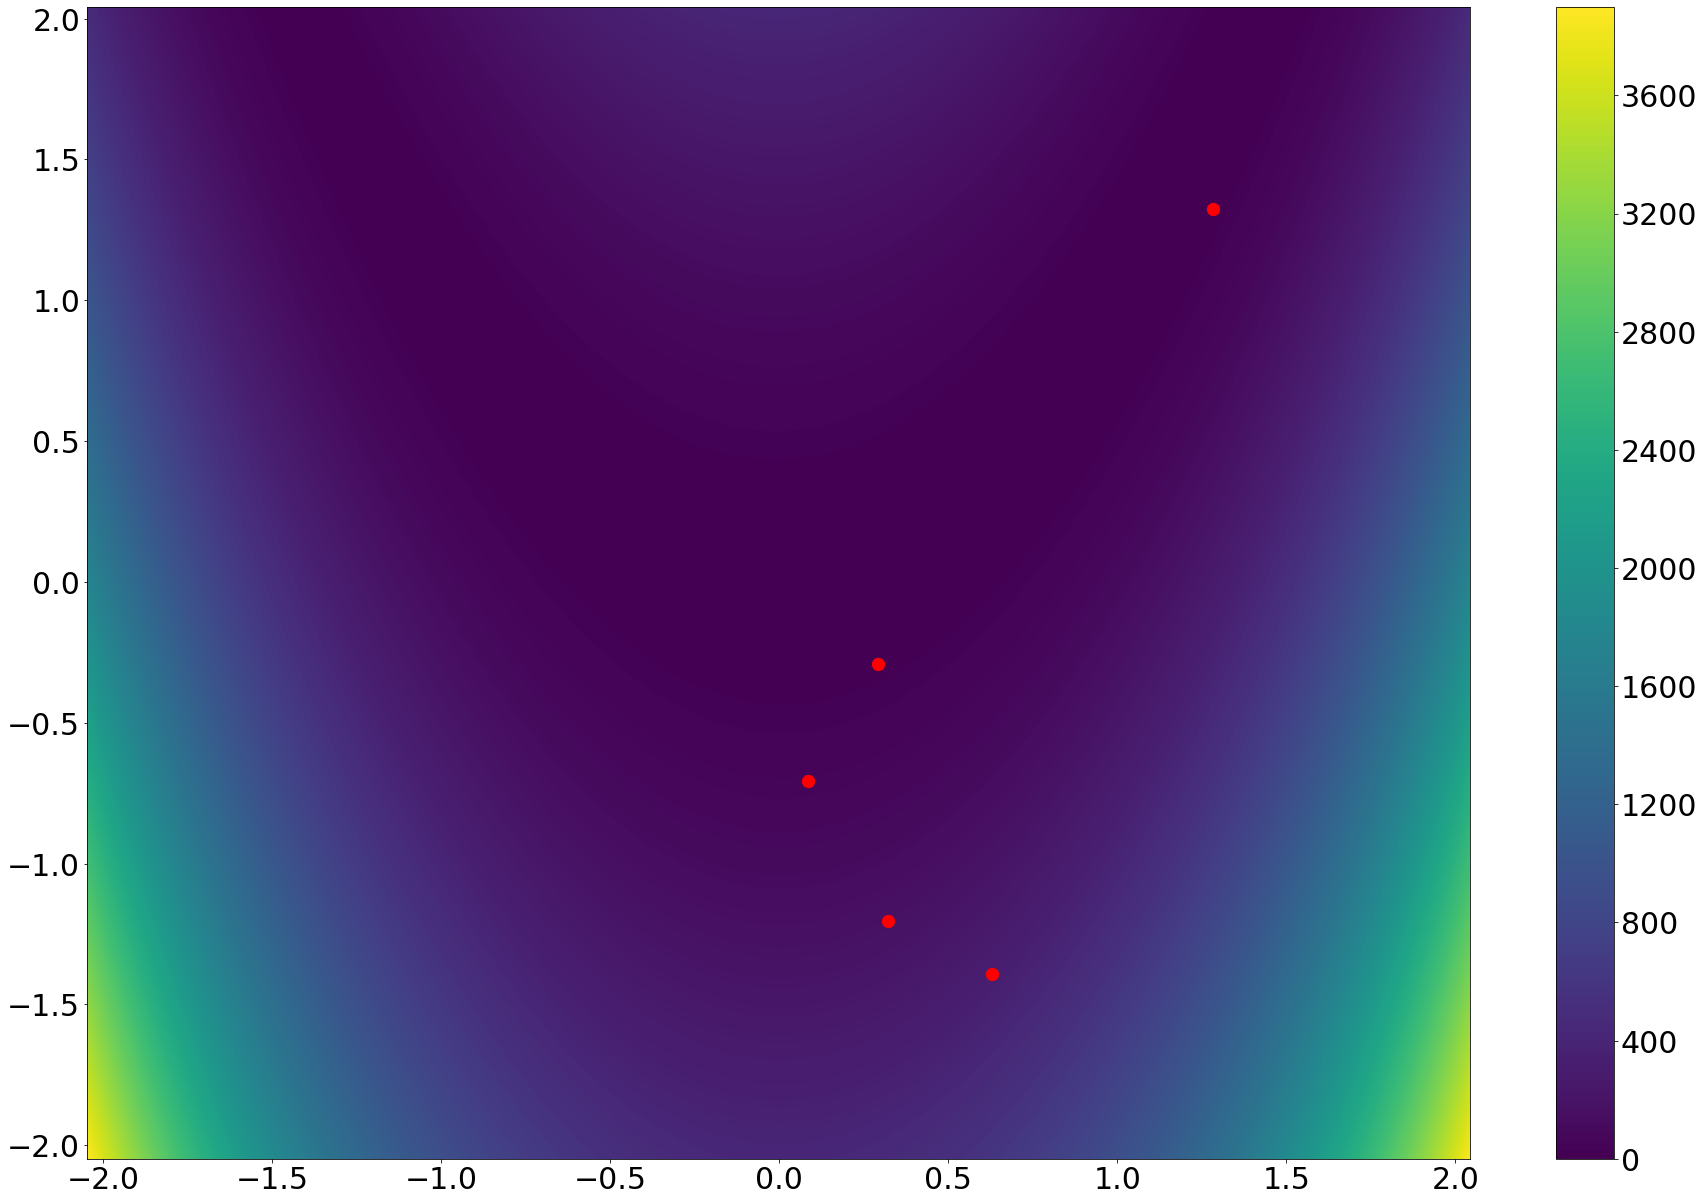

In [238]:
# defining initial data
random.seed(10)
data = generate_samples(5, f_bnds)

def plot_progress(data, input_bounds):
    # plot contour line and data points
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,4])

    # create mesh
    s = 0.01
    X = np.arange(input_bounds[0][0], input_bounds[0][1], s)
    Y = np.arange(input_bounds[1][0], input_bounds[1][1], s)
    X, Y = np.meshgrid(X, Y)

    # rosenbrock function
    Z = f(X,Y)

    # plot contour line
    clevf = np.arange(Z.min(),Z.max(), 10)
    CS = plt.contourf(X, Y, Z, clevf)
    fig.colorbar(CS)

    # plot initial data set
    ax.scatter([x[0] for x in data['X']], [x[1] for x in data['X']], c='r', s=150)

    plt.rcParams.update({'font.size': 30})
    plt.show()
    
plot_progress(data, f_bnds)

The main BO loop that minimizes the black-box function consists of:
1. Training the tree ensemble
2. Building optimization model
3. Proposing following input to look at
4. Evaluating the following input

After going through 80 iterations we plot the progress to see how the algorithm converges to the global minimum of the black-box function.

  0%|          | 0/80 [00:00<?, ?it/s]

/Users/alex/Documents/code_projects/condor-master/env/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


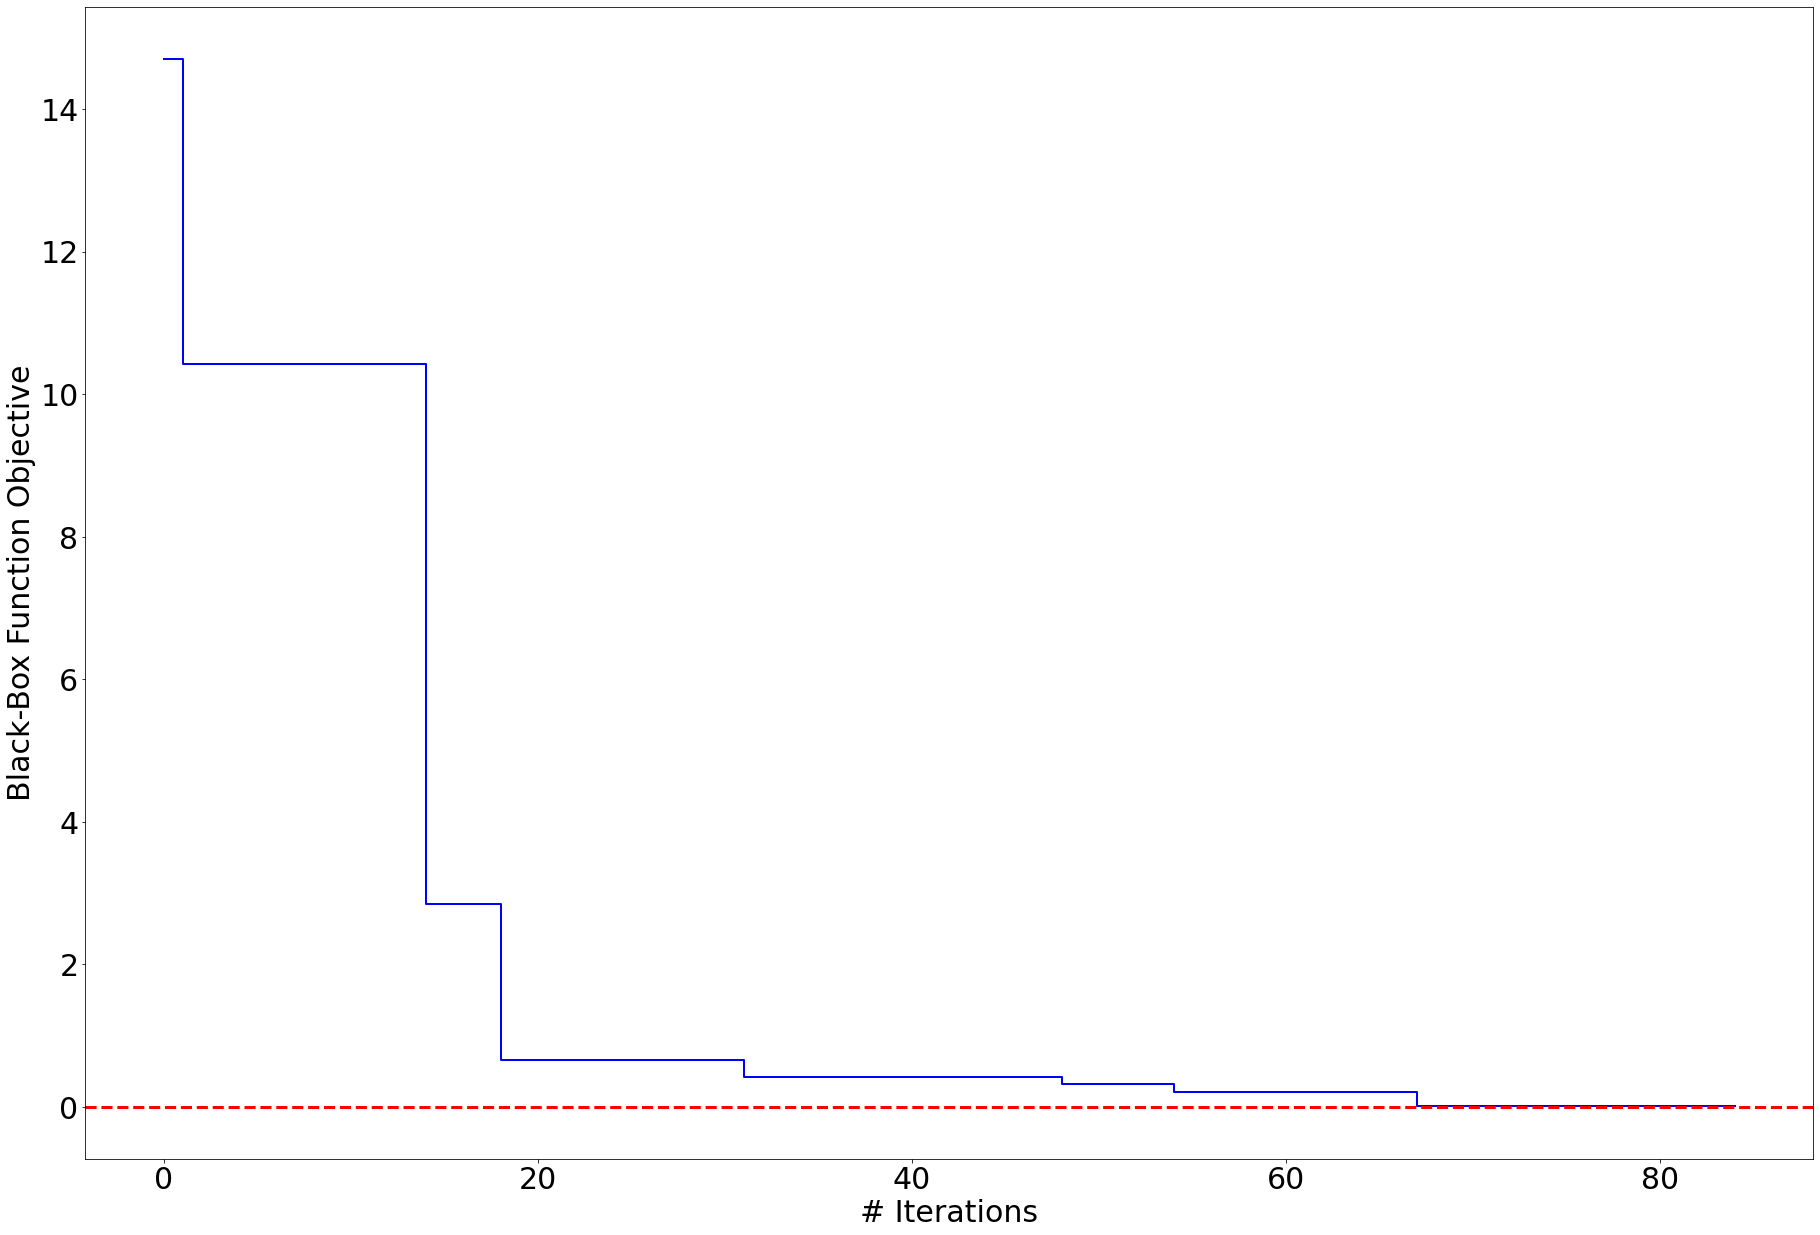

In [239]:
from tqdm.notebook import tqdm

for itr in tqdm(range(80)):
    # training the tree ensemble
    lgb_model = train_tree(data)

    # building the optimization model
    onnx_model = get_onnx_model(lgb_model)
    opt_model = pe.ConcreteModel()
    add_tree_model(opt_model, onnx_model, f_bnds)
    add_unc_metric(opt_model, data)
    opt_model.obj = pe.Objective(expr=opt_model.gbt.outputs[0] - 1.96*opt_model.alpha)
    
    # proposing following input to look at
    solver = pe.SolverFactory('gurobi')
    solver.options['NonConvex'] = 2
    solution = solver.solve(opt_model, tee=False)
    next_x = [opt_model.gbt.inputs[idx].value 
              for idx in range(len(opt_model.gbt.inputs))]
    
    # evaluating the following input
    next_y = f(next_x[0], next_x[1])

    data['X'].append(next_x)
    data['y'].append(next_y)
    
def plot_progress(data):  
    # set up plot
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,4])
    plt.ylabel("Black-Box Function Objective")
    plt.xlabel("# Iterations")

    # extract best_y
    min_y = []
    curr_min = data['y'][0]
    for y in data['y']:
        curr_min = min(y,curr_min)
        min_y.append(curr_min)
    
    # plot steps to show progress
    ax.step(np.arange(len(data['y'])), min_y, linewidth=2, color="b")
    plt.axhline(y=0.0, color='r', linewidth=3, linestyle='--')
    
    plt.show()

plot_progress(data)

## References
<a id="1">[1]</a> 
A. Thebelt, J. Kronqvist, M. Mistry, R. M. Lee, N. Sudermann-Merx, R.Misener, (2020). 
ENTMOOT: a framework for optimization over ensemble tree models. 
Computers & Chemical Engineering.

<a id="2">[2]</a> 
V. Mišić, (2020). 
Optimization of tree ensembles. 
Operations Research.